In [1]:
%load_ext autoreload
%autoreload 2

import logging
from reconstruct_frame import get_pipeline, get_source
from common import ExperimentManifest, ExperimentRun

from dsp import StatisticsCollector
import viz
import numpy as np
import IPython
import os

logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
exp_name = "/home/peter/pscc/evaluation/exp/dbpsk_final"
run = ExperimentManifest.load(exp_name).get_run_by_uuid("0d360e81-3587-45dd-bc6a-679fe38bfc49")
run.summary()

{'tx_platform': 'z390_linux',
 'tx_baudrate': 50,
 'tx_modulation': 'dbpsk',
 'tx_modulation_freqs': (12473.0,),
 'tx_mode': 'raw',
 'tx_loop_count': 1,
 'tx_loop_delay': 0.5,
 'tx_payload': b'\xbb\xe5\x9c6)}\xdbZ\x90B\xd9\xf2\xd5\x87A}',
 'tx_extra_args': [],
 'rx_ok': True,
 'rx_payload': b'\xbb\xe5\x9c6)}\xdb\xb5\xf1E\xd9\xf2\r\xe7\xf7p',
 'rx_frame_count': 1,
 'distance_m': 2.0,
 'base_filename': 'raw/dbpsk/12473.0/50/2.0m/0d360e81-3587-45dd-bc6a-679fe38bfc49',
 'uuid': '0d360e81-3587-45dd-bc6a-679fe38bfc49'}

In [9]:
source = get_source(run, exp_name, 4096)
pipeline = get_pipeline(run, source.fs)

preproc, demod, dcblocker, decoder = pipeline.children
sigdet, agc = preproc.sigdet, preproc.agc
cdr, deframer = decoder.children

pipeline = StatisticsCollector(pipeline, {
    "input_snr": lambda: sigdet.frag_snr_db,
    "agc_gain": lambda: agc.frag_gain_interp,
    "subcarrier_abs_amp": lambda: [demod.frag_f0_amp, demod.frag_f1_amp],
    "subcarrier_rela_amp": lambda: demod.frag_f1_f0_diff,
    "subcarrier_rela_amp_dc_blocked": lambda: dcblocker.frag_out,
    "symbols": lambda: cdr.symbols_hard,
    "symbol_rising_edges": lambda: cdr.symbol_rising_edges,
})

def get_ber(frame: bytes, run: ExperimentRun):
    rx_bits = np.unpackbits(np.frombuffer(frame, dtype=np.uint8))
    tx_bits = np.unpackbits(np.frombuffer(run.tx_payload, dtype=np.uint8))
    return np.mean(rx_bits != tx_bits)

Carrier cutoff = [12373. 12573.]


ValueError: too many values to unpack (expected 4)

In [10]:
source = get_source(run, exp_name, 4096)
pipeline = get_pipeline(run, source.fs)

preproc, demod, cdr, diffdecoder, deframer = pipeline.children
sigdet, agc = preproc.sigdet, preproc.agc

pipeline = StatisticsCollector(pipeline, {
    "input_snr": lambda: sigdet.frag_snr_db,
    "agc_gain": lambda: agc.frag_gain_interp,
    # "subcarrier_abs_amp": lambda: [demod.stat_phase_abs],
    # "subcarrier_abs_amp": lambda: [demod.frag_f0_amp, demod.frag_f1_amp],
    "loop_phase": lambda: demod.loop.stat_phase,
    "loop_freq": lambda: demod.loop.stat_freq,
    "loop_error": lambda: demod.loop.stat_e_raw,
    "demod_carrier": lambda: demod.stat_carrier,
    "subcarrier_rela_amp": lambda: demod.stat_phase_abs,
    "symbols": lambda: diffdecoder.stat_out,
    "symbol_rising_edges": lambda: cdr.symbol_rising_edges,
})

frames = []
with source:
    for block in source.stream:
        block_frames = pipeline(block)
        frames += block_frames
frames

Carrier cutoff = [12373. 12573.]


DEBUG:dsp.framing.deframer:Found SFD starting at [1]
DEBUG:dsp.framing.deframer:Consumed word 349
DEBUG:dsp.framing.deframer:Consumed word 0c6
DEBUG:dsp.framing.deframer:Consumed word 139
DEBUG:dsp.framing.deframer:RS buffer: Deframer.RSBuffer(len_target=3, len_parity=2, buf=bytearray(b'\x10`\x80'), erase_pos=[])
INFO:dsp.framing.deframer:Receiving a message with length 16
DEBUG:dsp.framing.deframer:Consumed raw byte bb
DEBUG:dsp.framing.deframer:Consumed raw byte e5
DEBUG:dsp.framing.deframer:Consumed raw byte 9c
DEBUG:dsp.framing.deframer:Consumed raw byte 36
DEBUG:dsp.framing.deframer:Consumed raw byte 29
DEBUG:dsp.framing.deframer:Consumed raw byte 7d
DEBUG:dsp.framing.deframer:Consumed raw byte 13
DEBUG:dsp.framing.deframer:Consumed raw byte 5a
DEBUG:dsp.framing.deframer:Consumed raw byte 90
DEBUG:dsp.framing.deframer:Consumed raw byte 46
DEBUG:dsp.framing.deframer:Consumed raw byte d9
DEBUG:dsp.framing.deframer:Consumed raw byte f2
DEBUG:dsp.framing.deframer:Consumed raw byte 55


[bytearray(b'\xbb\xe5\x9c6)}\x13Z\x90F\xd9\xf2U\x87Es')]

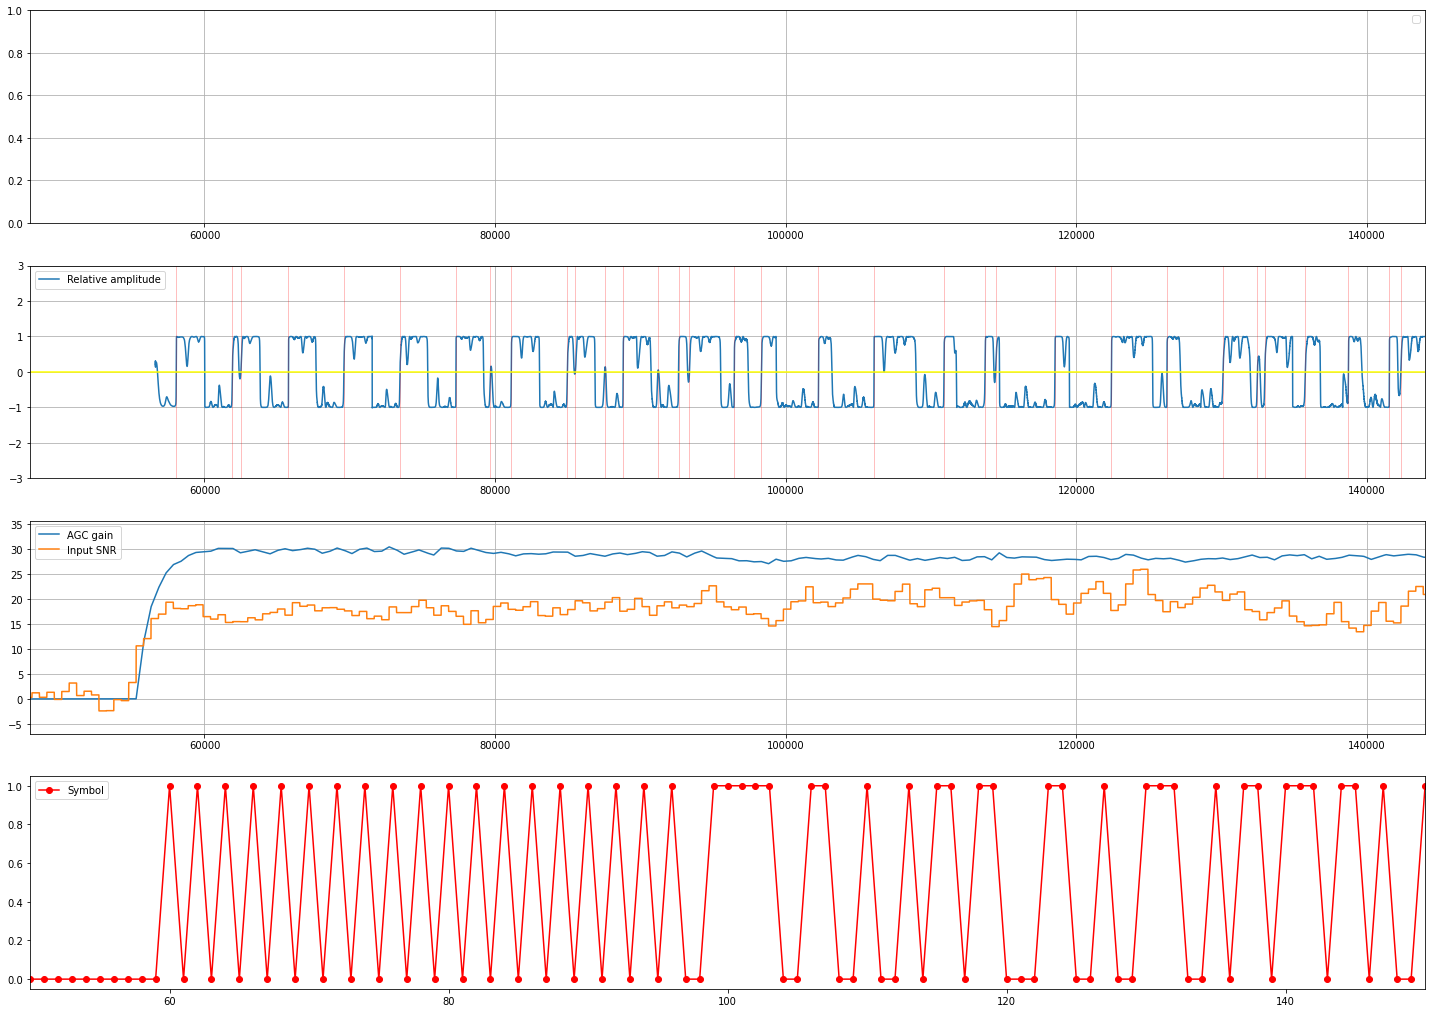

In [12]:
# \xf8(\xac\xea\x8a\xfb\x0b\x18n\x8a\x82\xd2j\x94\x8ek
start = 1.0
end = 3.0
viz.plot_statistics(pipeline, source.fs, run.tx_baudrate, start, end)

In [13]:
run.dump_log(exp_name, "stdout")

_8b_2_10b: abcdei=001111 / fghj=1001 / abcdeifghj=0011111001 / rd=+1
_8b_2_10b: abcdei=100100 / fghj=1011 / abcdeifghj=1001001011 / rd=+1
_8b_2_10b: abcdei=011000 / fghj=1100 / abcdeifghj=0110001100 / rd=-1
_8b_2_10b: abcdei=100111 / fghj=0010 / abcdeifghj=1001110010 / rd=-1
01010101 01010101 01010101 01010101 01010101 00111110 01100100 10110110 00110010 01110010 11011101 10100111 00111001 01101100 10010100 10111110 11011011 01011010 00001001 01000010 10011011 01001111 10101011 11100001 10000010 10111110 



(2202.0, 4404.0)

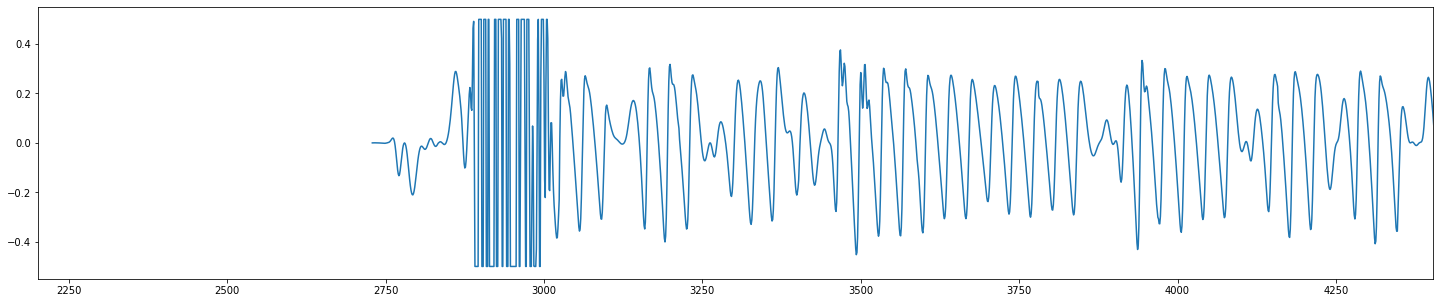

In [7]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(25, 5))
# plt.plot(pipeline.cum_data['loop_phase'])
# plt.plot(pipeline.cum_data['loop_freq'] * source.fs / np.pi / 2.0 * 8)
plt.plot(np.clip(pipeline.cum_data["loop_error"],-0.5, 0.5))
fac = source.fs / run.tx_modulation_freqs[0] * 5
plt.xlim((start * source.fs / fac, end * source.fs / fac))

In [10]:
audio_filename = os.path.join(exp_name, run.base_filename + ".wav")
IPython.display.Audio(audio_filename)

In [8]:
import soundfile as sf
x, fs = sf.read(audio_filename)
plt.specgram(x, NFFT=1024, Fs=fs, vmin=-103, vmax=-67, cmap="inferno")
# plt.ylim((run.tx_modulation_freqs[0] - 1000, run.tx_modulation_freqs[0] + 1000))
plt.show()

NameError: name 'audio_filename' is not defined